# Imports

In [115]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import urllib
from PIL import Image
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.svm import SVC

from scipy.spatial import KDTree
import webcolors

import os

from webcolors import CSS3_HEX_TO_NAMES

import skimage
import skimage.feature
import skimage.viewer
import sys

# Scrape Wikipedia for flags and download

In [116]:
def get_flags():
    site="https://en.wikipedia.org/wiki/Gallery_of_sovereign_state_flags"
    result = requests.get(site)
    soup=BeautifulSoup(result.text, 'html.parser')
    #print(soup.prettify()[:500])
    divs=soup.findAll('div', class_="mod-gallery mod-gallery-default")
    f=[]
    for x in divs:
        for y in x.findAll('img'):
            f.append(y)
    flags=[x.get('src') for x in f]
    #flags
    for u in flags:
        url='https:'+u
        #print(url)
        p=url.split('/')[-1]
        urllib.request.urlretrieve(url, 'flags/'+p)

In [117]:
#Wikipedia get annoyed with a lot of scraping, only do it the firt ime
#get_flags()

# Analyse colours in flags

## Get list of colours

In [118]:
colour_list=[]
# Read in flag images and measure pixel count by colour
for i in os.listdir('flags'):
    im = Image.open('flags/'+i)
    rgbimg = im.convert('RGBA')
    my_dict={}
    size=0
    for pixel in rgbimg.getdata():
        size+=1
        if pixel in my_dict:
            my_dict[pixel]+=1
        else:
            my_dict[pixel]=1
    #Remove colours present in small amounts due to aliasing
    for k, v in dict(my_dict).items():
        if v<100:
            my_dict.pop(k)
        else:
            colour_list.append(k)

In [119]:
#Remove transparent pixels due to shape of Nepalese flag
colour_list.remove((0, 0, 0, 0))
colour_list

[(35, 159, 64, 255),
 (60, 170, 86, 255),
 (133, 202, 149, 255),
 (183, 223, 192, 255),
 (208, 234, 214, 255),
 (255, 255, 255, 255),
 (218, 0, 0, 255),
 (247, 200, 200, 255),
 (235, 114, 114, 255),
 (0, 0, 0, 255),
 (206, 17, 38, 255),
 (255, 255, 255, 255),
 (0, 122, 61, 255),
 (255, 255, 255, 255),
 (255, 0, 0, 255),
 (255, 255, 255, 255),
 (220, 20, 60, 255),
 (255, 255, 255, 255),
 (1, 33, 105, 255),
 (200, 16, 46, 255),
 (105, 179, 231, 255),
 (73, 151, 208, 255),
 (195, 221, 240, 255),
 (255, 255, 255, 255),
 (0, 158, 96, 255),
 (168, 192, 47, 255),
 (252, 209, 22, 255),
 (188, 179, 80, 255),
 (58, 117, 196, 255),
 (255, 255, 255, 255),
 (84, 122, 195, 255),
 (0, 57, 166, 255),
 (70, 52, 121, 255),
 (213, 43, 30, 255),
 (116, 172, 223, 255),
 (209, 227, 244, 255),
 (255, 255, 255, 255),
 (209, 228, 244, 255),
 (0, 122, 94, 255),
 (206, 17, 38, 255),
 (252, 209, 22, 255),
 (0, 56, 147, 255),
 (220, 20, 60, 255),
 (255, 255, 255, 255),
 (255, 255, 255, 255),
 (218, 18, 26, 255),
 

## Cluster colours for names

In [120]:
colours=pd.DataFrame(colour_list, columns=['R', 'G', 'B', 'A'])
#colours=colours.drop('A', axis=1)
colours

,R,G,B,A
0,35,159,64,255
1,60,170,86,255
2,133,202,149,255
3,183,223,192,255
4,208,234,214,255
...,...,...,...,...
782,0,92,229,255
783,255,0,0,255
784,255,255,255,255
785,127,160,141,255


In [121]:
k_range = range(5, 15)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(colours)
    scores.append(metrics.silhouette_score(colours, kmT.labels_))
    inertia.append(kmT.inertia_)

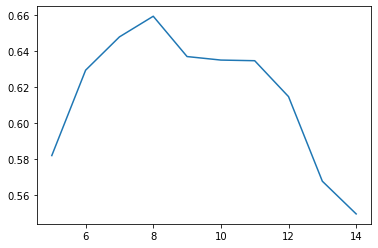

In [122]:
plt.plot(k_range, scores)

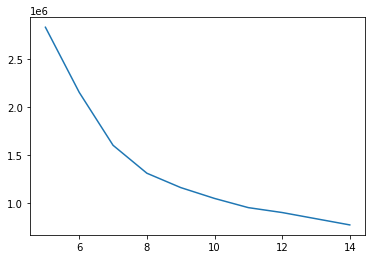

In [123]:
plt.plot(k_range, inertia)

In [124]:
km_colours = KMeans(n_clusters=10, random_state=124)
km_colours.fit(colours[['R', 'G', 'B']])

KMeans(n_clusters=10, random_state=124)

In [125]:
base_colours=km_colours.cluster_centers_
col_id=[x for x in range(0, len(base_colours))]

In [126]:
fig = px.imshow([base_colours])
fig.show()

In [127]:
colours['cluster']=km_colours.labels_
colours['cluster']=colours['cluster'].astype(str)
colours

,R,G,B,A,cluster
0,35,159,64,255,1
1,60,170,86,255,9
2,133,202,149,255,7
3,183,223,192,255,7
4,208,234,214,255,7
...,...,...,...,...,...
782,0,92,229,255,4
783,255,0,0,255,3
784,255,255,255,255,2
785,127,160,141,255,9


In [128]:
color_discrete_map={}
for i in range(0, len(base_colours)):
    color_discrete_map[str(i)]='rgb('+str(round(base_colours[i][0]))+','+str(round(base_colours[i][1]))+','+str(round(base_colours[i][2]))+')'

In [129]:
color_discrete_map

{'0': 'rgb(248,203,16)',
 '1': 'rgb(9,136,58)',
 '2': 'rgb(254,254,254)',
 '3': 'rgb(211,22,35)',
 '4': 'rgb(55,145,206)',
 '5': 'rgb(8,51,138)',
 '6': 'rgb(0,1,1)',
 '7': 'rgb(201,196,195)',
 '8': 'rgb(219,119,106)',
 '9': 'rgb(86,120,70)'}

In [130]:
fig=px.scatter_ternary(colours, a='R', b='G', c='B', color='cluster', color_discrete_map=color_discrete_map)
fig.show()

In [131]:
#km_colours.predict([[230, 180, 90]])[0]

### Read flags in

In [132]:
cols=col_id
cols

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [133]:
df=pd.DataFrame(columns=['Country', 'file']+cols)
#df.set_index('Country')
df

,Country,file,0,1,2,3,4,5,6,7,8,9


In [134]:
flag_list={}
for i in os.listdir('flags'):
    colour_percentage=[0]*(len(cols))
    name=re.search('Flag_of_(.+)\.svg', i).groups()[0]
    im = Image.open('flags/'+i)
    rgbimg = im.convert('RGB')
    my_dict={}
    size=0
    for pixel in rgbimg.getdata():
        size+=1
        if pixel in my_dict:
            my_dict[pixel]+=1
        else:
            my_dict[pixel]=1
    for k, v in dict(my_dict).items():
        if v<100:
            my_dict.pop(k)
        else:
            colour_list.append(k)
            flag_colour_id=km_colours.predict([k])[0]
            colour_percentage[flag_colour_id]+=v
    colour_percentage=[x/size for x in colour_percentage]
    #print(colour_percentage)
    df.loc[len(df)] =[name, i]+colour_percentage

/usr/lib/python3.9/site-packages/PIL/Image.py:962: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



In [135]:
df

,Country,file,0,1,2,3,4,5,6,7,8,9
0,Iran,175px-Flag_of_Iran.svg.png,0.000000,0.271371,0.316686,0.274343,0.000000,0.000000,0.000000,0.0304,0.009086,0.005829
1,Jordan,180px-Flag_of_Jordan.svg.png,0.000000,0.275926,0.194753,0.238827,0.000000,0.000000,0.275926,0.0000,0.000000,0.000000
2,Georgia,150px-Flag_of_Georgia.svg.png,0.000000,0.000000,0.631600,0.345467,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
3,Poland,160px-Flag_of_Poland.svg.png,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
4,Fiji,180px-Flag_of_Fiji.svg.png,0.000000,0.000000,0.081173,0.102222,0.648704,0.063951,0.000000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
201,Saint_Lucia,180px-Flag_of_Saint_Lucia.svg.png,0.064321,0.000000,0.020864,0.000000,0.853704,0.000000,0.029568,0.0000,0.000000,0.000000
202,Belize,167px-Flag_of_Belize.svg.png,0.000000,0.000000,0.036108,0.200000,0.000000,0.632814,0.000000,0.0000,0.000000,0.000000
203,Colombia,150px-Flag_of_Colombia.svg.png,0.500000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.0000,0.000000,0.000000
204,Slovenia,180px-Flag_of_Slovenia.svg.png,0.000000,0.000000,0.319444,0.333333,0.329444,0.000000,0.000000,0.0000,0.000000,0.000000


## Clean up names

## Cluster

In [136]:
b=df[[x for x in range(0, len(cols))]]

In [137]:
k_range = range(5, 100)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(b)
    scores.append(metrics.silhouette_score(b, kmT.labels_))
    inertia.append(kmT.inertia_)

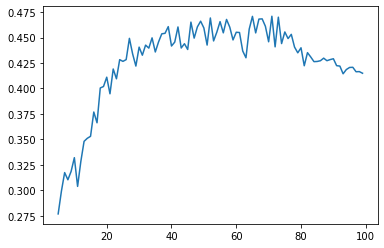

In [138]:
plt.plot(k_range, scores)

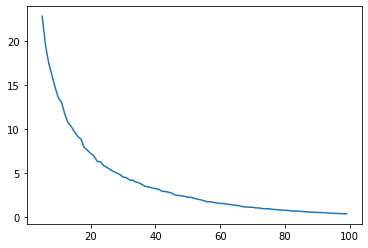

In [139]:
plt.plot(k_range, inertia)

In [140]:
cluster_size=30

In [148]:
km = KMeans(n_clusters=cluster_size, random_state=124)
km.fit(b)

KMeans(n_clusters=30, random_state=124)

In [149]:
df['cluster']=km.labels_

In [150]:
df

,Country,file,0,1,2,3,4,5,6,7,8,9,cluster
0,Iran,175px-Flag_of_Iran.svg.png,0.000000,0.271371,0.316686,0.274343,0.000000,0.000000,0.000000,0.0304,0.009086,0.005829,4
1,Jordan,180px-Flag_of_Jordan.svg.png,0.000000,0.275926,0.194753,0.238827,0.000000,0.000000,0.275926,0.0000,0.000000,0.000000,8
2,Georgia,150px-Flag_of_Georgia.svg.png,0.000000,0.000000,0.631600,0.345467,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,13
3,Poland,160px-Flag_of_Poland.svg.png,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,13
4,Fiji,180px-Flag_of_Fiji.svg.png,0.000000,0.000000,0.081173,0.102222,0.648704,0.063951,0.000000,0.0000,0.000000,0.000000,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Saint_Lucia,180px-Flag_of_Saint_Lucia.svg.png,0.064321,0.000000,0.020864,0.000000,0.853704,0.000000,0.029568,0.0000,0.000000,0.000000,6
202,Belize,167px-Flag_of_Belize.svg.png,0.000000,0.000000,0.036108,0.200000,0.000000,0.632814,0.000000,0.0000,0.000000,0.000000,3
203,Colombia,150px-Flag_of_Colombia.svg.png,0.500000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.0000,0.000000,0.000000,19
204,Slovenia,180px-Flag_of_Slovenia.svg.png,0.000000,0.000000,0.319444,0.333333,0.329444,0.000000,0.000000,0.0000,0.000000,0.000000,1


In [151]:
c=[]
for i in range(0, cluster_size):
    c.append(df[df['cluster']==i]['Country'].tolist())
c

[['Sri_Lanka', 'North_Macedonia', 'South_Ossetia', 'Spain', 'Bhutan'],
 ['the_Comoros', 'Luxembourg', 'Eswatini', 'Slovenia'],
 ['Trinidad_and_Tobago', 'the_Republic_of_China', 'Norway', 'Samoa'],
 ['the_Cook_Islands',
  'Kosovo',
  'Australia_%28converted%29',
  'Honduras',
  'Nauru',
  'the_Marshall_Islands',
  'Cape_Verde',
  'El_Salvador',
  'Iceland',
  'New_Zealand',
  'Belize'],
 ['Iran',
  'Niger',
  'Madagascar',
  'Kuwait',
  'Tajikistan',
  'Mexico',
  'Burundi',
  'Oman',
  'Somaliland',
  'Equatorial_Guinea',
  'Bulgaria',
  'Italy'],
 ['Syria', 'Yemen', 'Iraq', 'Sudan', 'Egypt', 'Pakistan'],
 ['Kazakhstan',
  'the_Federated_States_of_Micronesia',
  'Palau',
  'Somalia',
  'Saint_Lucia'],
 ['Cyprus', 'Japan', 'the_Turkish_Republic_of_Northern_Cyprus', 'South_Korea'],
 ['Jordan',
  'Jamaica',
  'Afghanistan',
  'South_Sudan',
  'the_Sahrawi_Arab_Democratic_Republic',
  'Malawi',
  'Tanzania',
  'the_United_Arab_Emirates',
  'Saint_Kitts_and_Nevis',
  'Palestine',
  'Vanuatu

In [152]:
def merge_images(image1, image2):
    #image1=Image.open(file1)
    #image2=Image.open(file2)
    (width1, height1)=image1.size
    (width2, height2)=image2.size
    result_width=width1+width2
    result_height=max(height1, height2)
    result=Image.new('RGB', (result_width, result_height))
    result.paste(im=image1, box=(0,0))
    result.paste(im=image2, box=(width1,0))
    return result

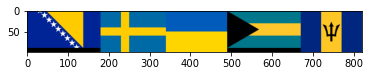

In [153]:
z=df[df['cluster']==23]['file'].tolist()
end=merge_images(Image.open('flags/'+z[0]), Image.open('flags/'+z[1]))
plt.imshow(end)
for i in range(2, len(z)):
    im = Image.open('flags/'+str(z[i]))
    end=merge_images(end, im)
plt.imshow(end)

## Shape analysis

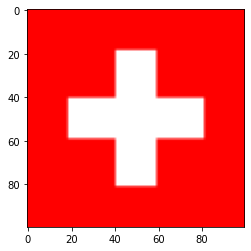

In [154]:
im = Image.open('flags/100px-Flag_of_Switzerland.svg.png')
im = im.convert('RGB')
plt.imshow(im)

In [155]:
filename='flags/100px-Flag_of_Switzerland.svg.png'
image = skimage.io.imread(fname=filename, as_gray=True)
#viewer = skimage.viewer.ImageViewer(image=image)
#viewer.show()

In [156]:
edges = skimage.feature.canny(
    image=image,
    sigma=2,
    low_threshold=0.1,
    high_threshold=0.3,
)

In [157]:
#viewer = skimage.viewer.ImageViewer(edges)
#viewer.show()

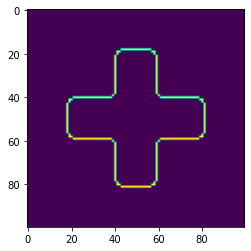

In [158]:
edges
plt.imshow(edges)

In [159]:
flag_edges_list=[]
for i in os.listdir('flags'):
    #colour_percentage=[0]*(len(cols))
    name=re.search('Flag_of_(.+)\.svg', i).groups()[0]
    filename='flags/'+i
    image = skimage.io.imread(fname=filename, as_gray=True)
    #im = Image.open('flags/'+i)
    #print(im.size)
    #ratio=min(180/im.size[0], 100/im.size[1])
    #print(ratio)
    edges = skimage.feature.canny(
        image=image,
        sigma=2,
        low_threshold=0.1,
        high_threshold=0.3,
    )
    flag_edges_list.append(edges)


In [160]:
flag_edges_normalise=[]
for a in flag_edges_list:
    i=a.tolist()
    height = len(i)
    width=len(i[0])
    if height<100:
        while len(i)<100:
            i.append([False]*len(i[0]))
    if width<180:
        for j in i:
            j.extend([False]*(180-width))
    print(type(i))
    flag_edges_normalise.append(i)
    #print(str(i[0].size) +', '+ str(len(i)))
    #if len(i)<100:
    #    print(i[0])
    #    print(len(i[0]))
    #    i=np.append(i, [False]*len(i[0]))
    #    print(i)
    #print(str(i[0].size) +', '+ str(len(i)))
    #if str(i[0].size < 180
    #    i.append([False]*)
#Max wisth 180, height 100

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

In [161]:
for i in flag_edges_normalise:
    print(type(i))
    print(len(i))
    print(len(i[0]))

<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'list'>
100
180
<class 'lis

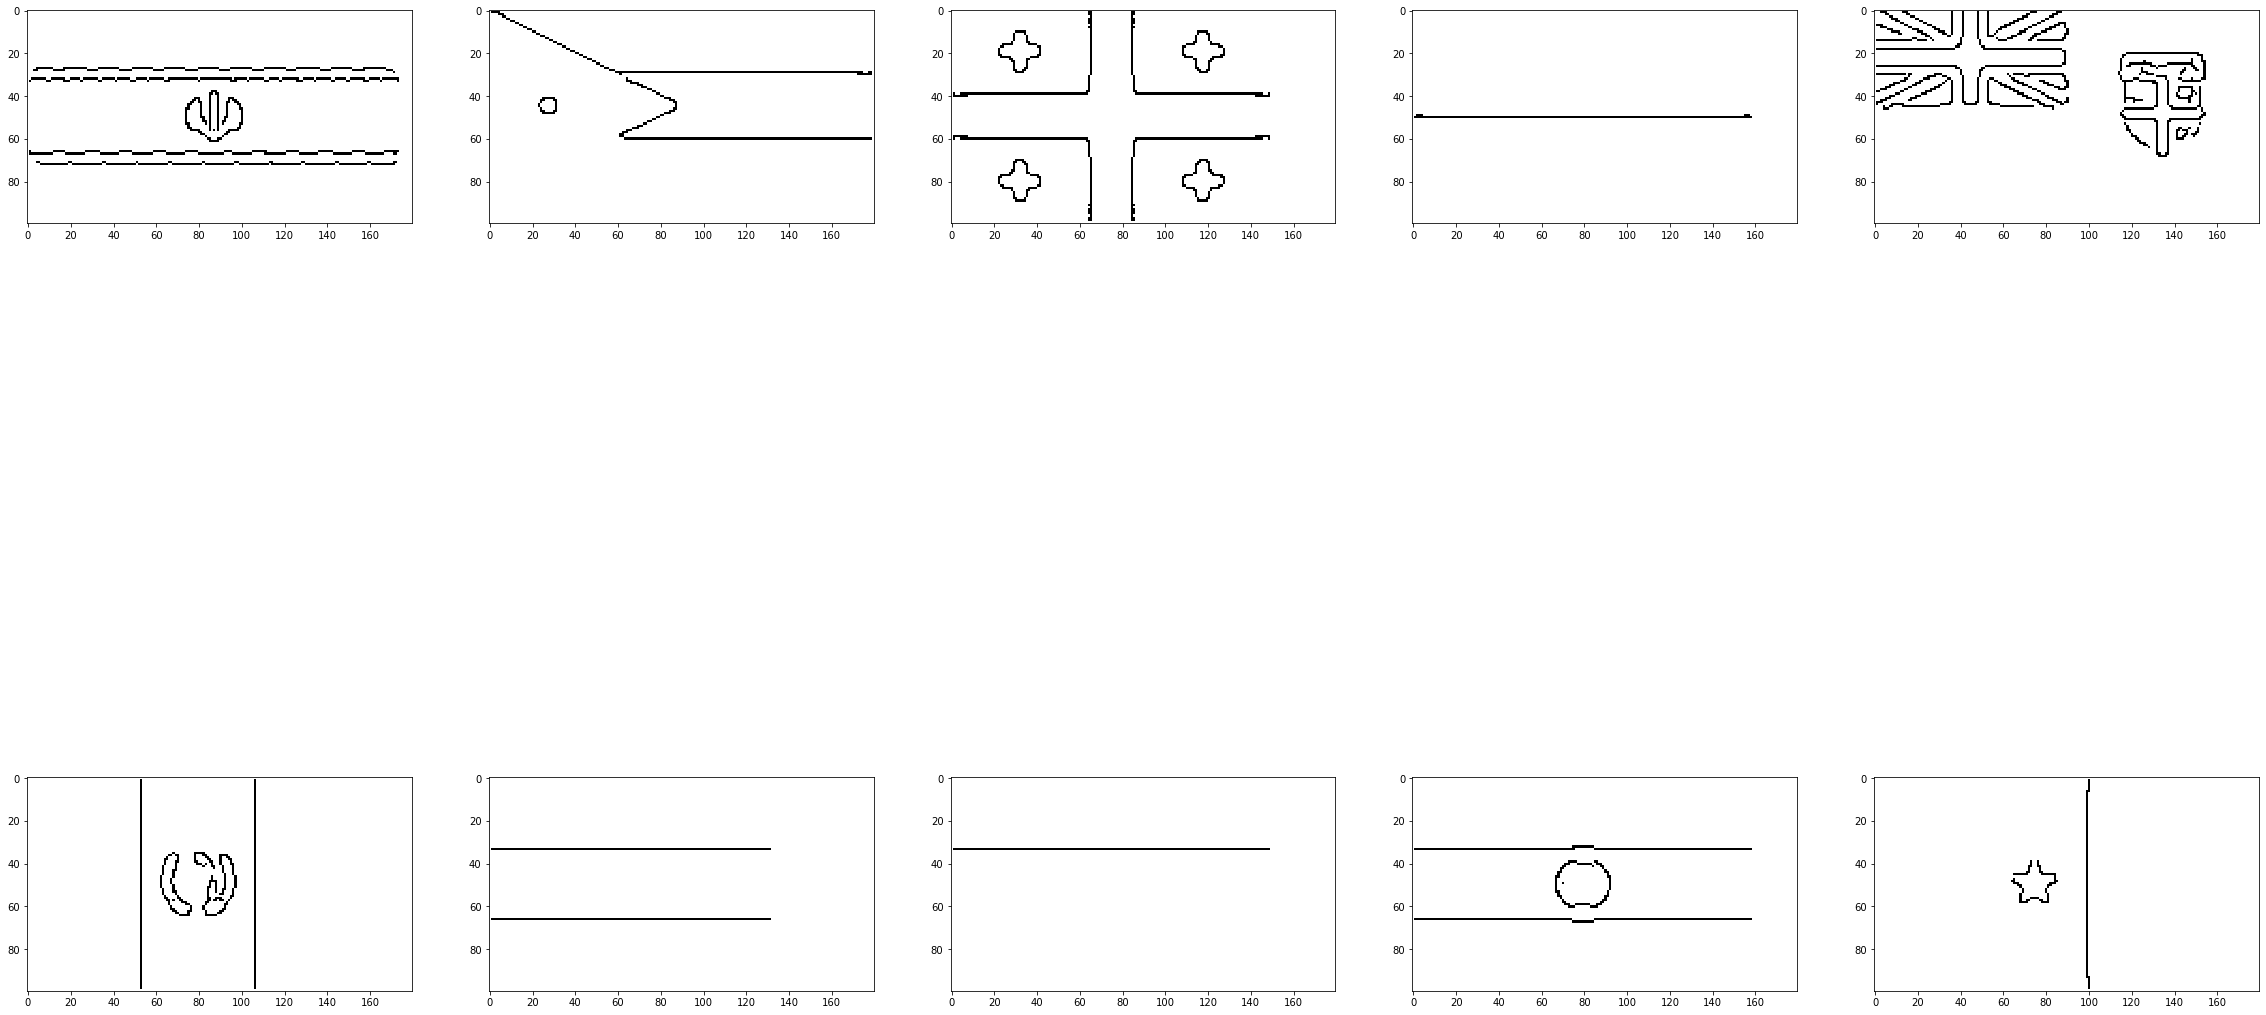

In [162]:
plt.figure(figsize=(40,40))
for i, image in enumerate(flag_edges_normalise[:10]):
    #initializing subplot of 3x5
    plt.subplot(3,5, i+1)
    #display images in the subplots
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    #set title for each subplot
    #plt.title("Training: %i" % label)